In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
from plotly.offline import plot
import networkx as nx
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import streamlit as st
from pyngrok import ngrok
import pandas as pd

In [2]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

c:\Users\putte\miniconda3\envs\dataviz\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [3]:
df = pd.read_csv("../ETL/main_file.csv")

In [4]:
df_abstract_2018 = df.loc[df.year == 2018, 'abstract']

In [51]:
abstract = df_abstract_2018.dropna()

In [52]:
# words = abstract.values
# vectors = model.encode(words)

In [53]:
words = abstract.values
vectors = np.load('2018_vectors.npy')

In [7]:
# np.savetxt('2018_words.txt', words, fmt='%s')
# np.save('2018_vectors.npy', vectors)

In [54]:
sims = cosine_similarity(vectors, vectors)

In [55]:
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i<=j:
            sims[i, j] = False

In [102]:
indices = np.argwhere(sims > 0.8) ## we get those were the similarity is higher than .65

In [103]:
G = nx.Graph()

for index in indices:
    G.add_edge(words[index[0]], words[index[1]], 
               weight=sims[index[0], index[1]]) ## Cria um vertice, caso nao exista

In [104]:
weight_values = nx.get_edge_attributes(G, 'weight')

In [105]:
positions = nx.spring_layout(G)

In [106]:
nx.set_node_attributes(G, name='position', values=positions)

In [39]:
'''
Quando passamos palavras para buscar,
elas apareceram representadas por circulos
maiores no grafico
'''
searches = []

# OG Visualization using Scatter

In [110]:
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
## Cria os vertices
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    opacity=0.7,
    line=dict(width=2, color='White'),
    hoverinfo='text',
    mode='lines')

edge_trace.text = weights


node_x = []
node_y = []
sizes = []
## Cria os nos
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    if node in searches:
        sizes.append(50)
    else:
        sizes.append(15)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        line=dict(color='White'),
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Picnic',
        reversescale=False,
        color=[],
        opacity=0.9,
        size=sizes,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

invisible_similarity_trace = go.Scatter(
    x=ave_x, y=ave_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        opacity=0,
    )
)

invisible_similarity_trace.text=weights

In [111]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [112]:
fig = go.Figure(
    data=[edge_trace, node_trace, invisible_similarity_trace],
    layout=go.Layout(
        title='Network Graph of Word Embeddings',
        template='plotly_dark',
        titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text="Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) 
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

plot(fig)

'temp-plot.html'

# Network Centrality Measures and Their Visualization

In [76]:
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [77]:
def draw_return_fig(G, pos, measures, measure_name):
    fig, ax = plt.subplots()
    nodes = nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    ax.set_title(measure_name)  # Setting title using ax, not fig
    fig.colorbar(nodes)
    ax.axis('off')  # Setting axis off using ax, not fig
    return fig

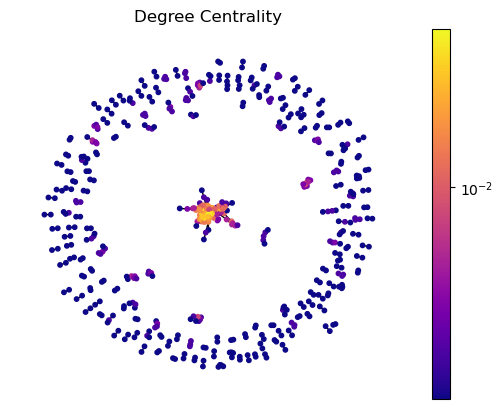

In [107]:
draw(G, positions, nx.degree_centrality(G), 'Degree Centrality')

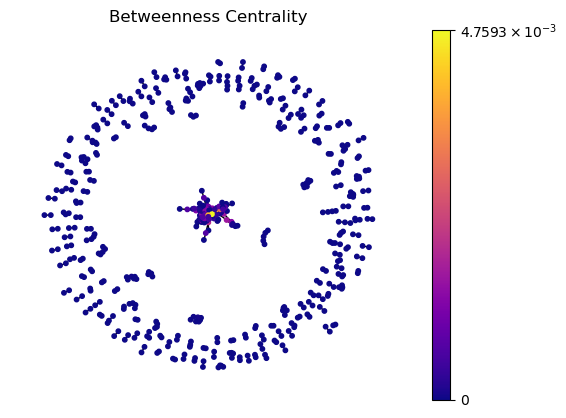

In [108]:
draw(G, positions, nx.betweenness_centrality(G), 'Betweenness Centrality')

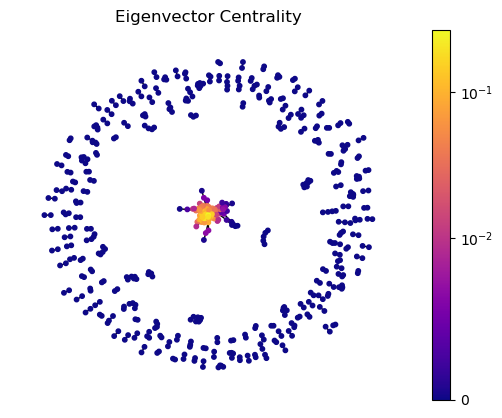

In [109]:
draw(G, positions, nx.eigenvector_centrality(G), 'Eigenvector Centrality')

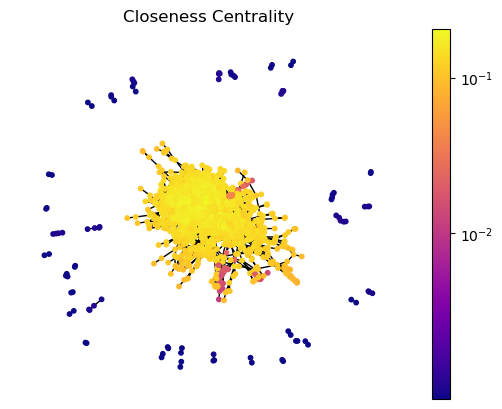

In [87]:
draw(G, positions, nx.closeness_centrality(G), 'Closeness Centrality')

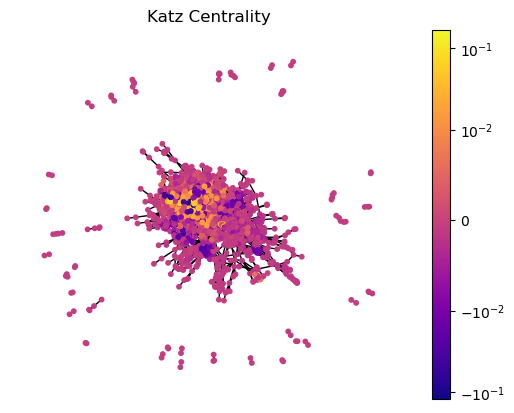

In [91]:
draw(G, positions, nx.katz_centrality_numpy(G, alpha=0.1, beta=1.0), 'Katz Centrality')

In [57]:
net_fig = draw_return_fig(G, positions, nx.betweenness_centrality(G), 'Betweenness Centrality')
st.pyplot(net_fig)

DeltaGenerator()